In [1]:
# imports
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
import os
import math
import random
import timeit

In [2]:
# 1.2 plot

def plot_lines(img, lines):
    res = img.copy()
    if lines is None:
        return res
    for i in range(len(lines)):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = rho * a
        y0 = rho * b
        pt1 = (int(x0 + 10000 * (-b)), int(y0 + 10000 * (a)))
        pt2 = (int(x0 - 10000 * (-b)), int(y0 - 10000 * (a)))
        cv.line(res, pt1, pt2, (0, 0, 255), 3, cv.LINE_AA)
    return res


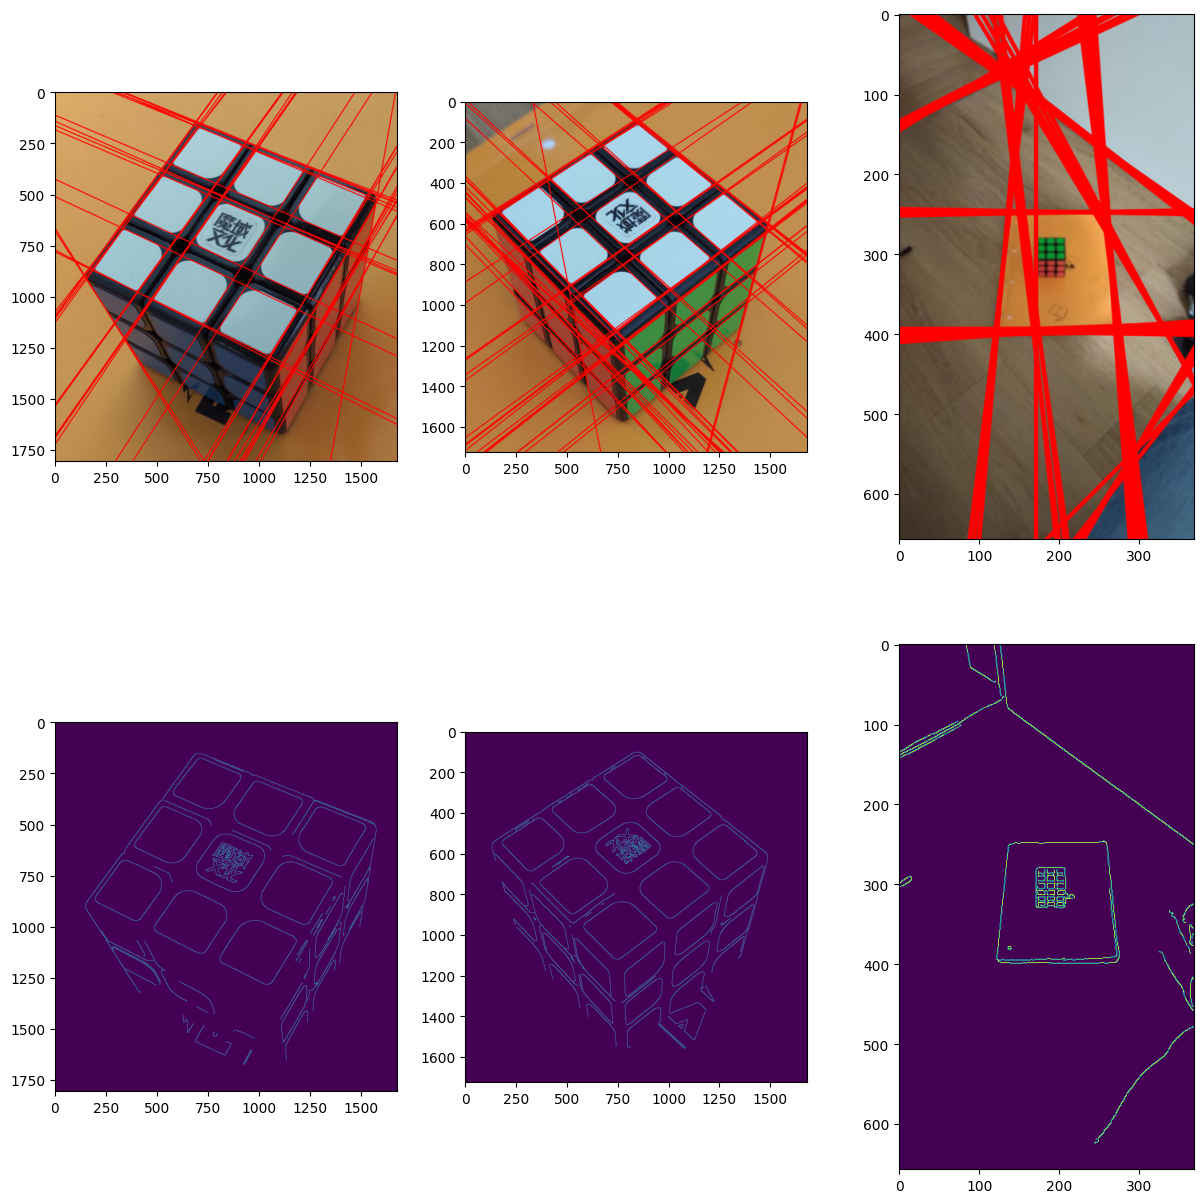

In [3]:
im1 = cv.imread('data/rubik1.jpg')
im2 = cv.imread('data/rubik2.jpg')
im3 = cv.imread('data/rubik5.jpg')

im1 = cv.GaussianBlur(im1, (5,5),1)
im2 = cv.GaussianBlur(im2, (5,5),1)
im3 = cv.GaussianBlur(im3, (5,5),1)

# 1.1 Hougs transform

canny_edge_1 = cv.Canny(im1, 80, 180, None, 3)
canny_edge_2 = cv.Canny(im2, 80, 180, None, 3)
canny_edge_3 = cv.Canny(im3, 50, 200, None, 3)

im1l = cv.HoughLines(canny_edge_1, 1, np.pi / 180.0, 150)
im2l = cv.HoughLines(canny_edge_2, 1, np.pi / 180.0, 150)
im3l = cv.HoughLines(canny_edge_3, 1, np.pi / 180.0, 50)

im1l = plot_lines(im1, im1l)
im2l = plot_lines(im2, im2l)
im3l = plot_lines(im3, im3l)


im1l = cv.cvtColor(im1l, cv.COLOR_BGR2RGB)
im2l = cv.cvtColor(im2l, cv.COLOR_BGR2RGB)
im3l = cv.cvtColor(im3l, cv.COLOR_BGR2RGB)

row = 2
col = 3
i = 1
plt.figure(figsize=(15, 15))
plt.subplot(row, col, i), plt.imshow(im1l)
i+=1
plt.subplot(row, col, i), plt.imshow(im2l)
i+=1
plt.subplot(row, col, i), plt.imshow(im3l)
i+=1
plt.subplot(row, col, i), plt.imshow(canny_edge_1)
i+=1
plt.subplot(row, col, i), plt.imshow(canny_edge_2)
i+=1
plt.subplot(row, col, i), plt.imshow(canny_edge_3)
i+=1
plt.show()

# A. Computing vanishing points: questions

## 1. The number of vanishing points

Between 0 and 3 finite vanishing points can be found from all possible images of a Rubik's cube. This is because our 3D world, once projected onto a 2D photography only has 3 degrees of freedom for the viewpoint: Left and right, up and down, forward and backward.

For the minimum, the least you can have is 0
- When you take a really zoomed in picture (inside a green square for exemple with no edge visible) because there will be no parallel lines. 
- When you take a perfect picture of a single face like a 2D square, because the lines on the Rubik's Cube will be parallel and will have the same depth (to the camera), the lines projected onto the image in 2D will be perfectly parallel and will never intersect to give vanishing points.

But for a more realistic picture where you can see only one whole face, there will be probably a rotation so, even if it will be a 2d square with only x and y axis, thoses axis parallel lines will converge to a single point for at least one axis event if it is really far, giving 1 vanishing points.





## 2 Is there a relation between number of visible faces and vanishing points?
Yes, there will be one vanishing point per axis transformed, with a maximum of three for a normal camera projection

## 3 Can you find 4 vanishing points in Rubik’s cube images? If yes, demonstrate with an image.

No, we will never be able to find a 4th vanishing point because the photo takes a 3D image (our world) onto a 2D image, so there are only 3 axes to be deformed by the perspective which means that we will only be able to fid 3 vanishing points at most. That's only 

If you change perspective to deform parallels (like a fish eye camera) you may be able to find more than 3 vanishing points, because line will become curved and will be able to intersect more than 3 times. this is not possible with a normal camera, but specialized fish eye cameras can do that and you will be able to find <a href="https://ieeexplore.ieee.org/document/5190078">4 vanishing points.</a>

## 4. Can you find a configuration with at least one vanishing point outside the image? 

Vanishing points can be outside of the image. Take the following picture for example:

<img src="data/rubik4.jpg" width="200"></img>

In [4]:
# sort lines by theta
def sort_lines(lines):
    lines = lines.tolist()
    lines.sort(key=lambda x: x[0][1])
    return np.array(lines)

def cleanLines(lines, threshold):
    cleaned = []
    thetaPrev = -1
    for i in range(len(lines)):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        if thetaPrev == -1 or abs(theta - thetaPrev) > threshold:
            if i > 0:
                thetaLast = cleaned[-1][0][1]
                cleaned.append(lines[i - 1])
                thetaLast2 = cleaned[-1][0][1]
                if thetaLast == thetaLast2:
                    cleaned.pop()
                    cleaned.pop()
                # print("rhop: ", rhoPrev, "thetap: ", thetaPrev)
            cleaned.append(lines[i])
            # print("rho: ", rho, "theta: ", theta)
        thetaPrev = theta
    return np.array(cleaned)

def print_cleaned(lineclean):
    for i in range(len(lineclean)):
        rho = lineclean[i][0][0]
        theta = lineclean[i][0][1]
        print("rho: ", rho, "theta: ", theta)



# 1.3 each group is two consecutive lines compute intersection between them

def compute_intersection(line1, line2):
    rho1 = line1[0][0]
    theta1 = line1[0][1]
    rho2 = line2[0][0]
    theta2 = line2[0][1]
    a = np.array([[np.cos(theta1), np.sin(theta1)], [np.cos(theta2), np.sin(theta2)]])
    b = np.array([rho1, rho2])
    x0, y0 = np.linalg.solve(a, b)
    return x0, y0

def compute_intersections(lines):
    intersections = []
    #compute l1, l2 then l3, l4 then l5, l6...
    for i in range(0, len(lines), 2):
        if i + 1 < len(lines):
            intersections.append(compute_intersection(lines[i], lines[i + 1]))
    return intersections

def print_intersections(intersections):
    for i in range(len(intersections)):
        print("x: ", intersections[i][0], "y: ", intersections[i][1])


im1l = sort_lines(im1l)
clean = cleanLines(im1l, 4)
intersections = compute_intersections(clean)

print_intersections(intersections)



x:  -1117.8672526149292 y:  228.17847068402568
x:  -651.1201131192154 y:  -3286.552722011381
x:  89.03729710380304 y:  -234.08720421275828
x:  -17.842700038711765 y:  -261.5503953995988
x:  1988.8707732816579 y:  -2500.387558267078
x:  -182.18499837862794 y:  159.24859092719367
x:  -214.03022087408183 y:  -184.87476397187268


## Computing vanishing point

To compute them, we sorted the lines by their angle, then clean the lines given by the hough transform to keep only two lines with approximately the same angle. Then we compute the intersection of the two lines to find the vanishing point. There is an error, and if more than one group represent the same vanishing point, because the lines are really close in angle, we have multiple points really far from each other. 

# Estimating fundamental matrix

## Point correspondences

We made a simple interface to select points on the image. It's commented by default in the code, but you can uncomment it to use it instead of raw data we hardcoded.

## Estimation

To estimate the fundamental matrix, we used the 8-point algorithm. With a RANSAC that is picking 8 samples each tries, create a matrix, and store the configuration that has the most inliers. We then use this configuration to display the epipolar lines.

In [5]:
# part B : Computing fundamental matrix

# functions to get the matching points from the user
def get_points_from_user(image):
    # Function to handle mouse clicks
    def click_event(event, x, y, flags, param):
        if event == cv.EVENT_LBUTTONDOWN:
            points.append((x, y))
            cv.circle(param['image'], (x, y), 5, (0, 255, 0), -1)
            cv.imshow(param['window_name'], param['image'])

    # Display image
    cv.imshow('Image', image)

    # Initialize array to store points
    points = []

    # Set the mouse callback function
    cv.setMouseCallback('Image', click_event, {'image': image, 'window_name': 'Image'})

    # Wait until the user clicks on the image
    while True:
        key = cv.waitKey(1)
        if key == 13 or key == 27:  # Break if 'Enter' is pressed
            break

    # Convert points to NumPy array
    points_array = np.array(points)

    return points_array

def get_matching_points_from_user(image1, image2):
    clicked_points_image1 = get_points_from_user(image1)
    clicked_points_image2 = get_points_from_user(image2)
    cv.destroyAllWindows()
    return clicked_points_image1, clicked_points_image2

# match the points together
def create_matching_points(array1, array2):
    matching_points = list(zip(array1, array2))
    return matching_points

def display_matched_points(image1, image2, matching_points):
    # Concatenate the two images horizontally
    result_image = np.hstack((image1, image2.copy()))

    # Convert points to integer
    matching_points = np.int32(matching_points)

    # Draw lines connecting matched points
    for point1, point2 in matching_points:
        point2[0] += image1.shape[1]  # Adjust x-coordinate for the second image
        cv.line(result_image, tuple(point1), tuple(point2), (0, 255, 0), 2)

    # Display the result image in a plot
    plt.figure(figsize=(15, 15))
    plt.imshow(result_image)
    plt.axis('off')
    plt.show()

def pad_to_3D(point):
    return np.hstack((point, 1))

def pad_to_3DArray(points):
    return np.hstack((points, np.ones((points.shape[0], 1))))

def fundamentalQuality(p1, p2, matrix):
    p1 = pad_to_3D(p1)
    p2 = pad_to_3D(p2)
    epipolar_constraint = p2 @ matrix @ p1
    return epipolar_constraint ** 2

    # the closest the values to 0 = the best estimated matrix
        
def fundamentalQualityArray(pls, prs, matrix):
    s = 0
    for i in range(len(pls)):
        s += fundamentalQuality(pls[i], prs[i], matrix)
    return s / len(pls)

def normalize_points(points):
    # Normalize the points to have zero mean and a mean distance of sqrt(2)
    mean = np.mean(points, axis=0)
    std_dev = np.std(points)
    scale = np.sqrt(2) / std_dev
    translation_matrix = np.array([[scale, 0, -scale * mean[0]],
                                   [0, scale, -scale * mean[1]],
                                   [0, 0, 1]])
    normalized_points = np.dot(translation_matrix, np.vstack((points.T, np.ones(len(points)))))
    return normalized_points[:2].T, translation_matrix

def Fundamental_normalized(points1, points2):

    # Normalize the points
    normalized_points1, T1 = normalize_points(points1)
    normalized_points2, T2 = normalize_points(points2)

    # Build the A matrix for the linear least squares problem
    A = np.column_stack((normalized_points1[:, 0] * normalized_points2[:, 0],
                         normalized_points1[:, 0] * normalized_points2[:, 1],
                         normalized_points1[:, 0],
                         normalized_points1[:, 1] * normalized_points2[:, 0],
                         normalized_points1[:, 1] * normalized_points2[:, 1],
                         normalized_points1[:, 1],
                         normalized_points2[:, 0],
                         normalized_points2[:, 1],
                         np.ones(len(points1))))

    _, _, V = np.linalg.svd(A)
    F = V[-1].reshape(3, 3)

    U, S, V = np.linalg.svd(F)
    S[2] = 0
    F = np.dot(U, np.dot(np.diag(S), V))

    F = np.dot(T2.T, np.dot(F, T1))

    return F / F[2, 2]

def Fundamental(points1, points2):

    # Build the A matrix for the linear least squares problem
    A = np.column_stack((points1[:, 0] * points2[:, 0],
                         points1[:, 0] * points2[:, 1],
                         points1[:, 0],
                         points1[:, 1] * points2[:, 0],
                         points1[:, 1] * points2[:, 1],
                         points1[:, 1],
                         points2[:, 0],
                         points2[:, 1],
                         np.ones(len(points1))))
    # compute the SVD of A
    _, _, V = np.linalg.svd(A)
    # take the last column of V as the fundamental matrix
    F = V[-1].reshape(3, 3)
    U, S, V = np.linalg.svd(F)
    S[2] = 0
    F = np.dot(U, np.dot(np.diag(S), V))
    return F / F[2, 2]

def isCombinationUsed(combination, usedCombination):
    for i in range(len(usedCombination)):
        if np.array_equal(combination, usedCombination[i]):
            return True
    return False

def ransac_fundamental(pleft, pright, normalized=False, k=50, threshold=0.1):
    # Ensure points are 2D arrays
    points1 = np.array(pleft)
    points2 = np.array(pright)

    # Check if the number of points is at least 8
    if len(points1) < 8 or len(points2) < 8:
        raise ValueError("At least 8 corresponding points are required to compute the fundamental matrix.")
    
    if len(points1) != len(points2):
        raise ValueError("The number of points in both images must be the same.")
    
    bestF = None
    bestInliersLeft = []
    bestInliersRight = []
    # map of used combinations
    # usedCombination = []

    for i in range(k):
        # Choose 8 random points
        random_indices = np.random.choice(len(points1), 8)
        # check if the combination was already used
        # while isCombinationUsed(random_indices, usedCombination):
        #     random_indices = np.random.choice(len(points1), 8)
        # usedCombination.append(random_indices)
        random_points1 = points1[random_indices]
        random_points2 = points2[random_indices]

        # Compute the fundamental matrix
        if normalized:
            F = Fundamental_normalized(random_points1, random_points2)
        else:
            F = Fundamental(random_points1, random_points2)

        # Compute the inliers
        inliersLeft = []
        inliersRight = []
        for j in range(len(points1)):
            point1 = points1[j]
            point2 = points2[j]
            if fundamentalQuality(point1, point2, F) < threshold:
                inliersLeft.append(point1)
                inliersRight.append(point2)

        # Update the best fundamental matrix
        if len(inliersLeft) > len(bestInliersLeft):
            bestF = F
            bestInliersLeft = inliersLeft
            bestInliersRight = inliersRight
            
    return bestF, np.array(bestInliersLeft), np.array(bestInliersRight)

def drawLineOnImage(image, lines):
    img = image.copy()
    for line in lines:
        a, b, c = line[0]
        x0, y0, x1, y1 = map(int, [0, -c/b, image.shape[1], -(c+a*image.shape[1])/b])
        cv.line(img, (x0, y0), (x1, y1), (0, 255, 0), 1)
    return img

def display_epipolar_lines(imgLeft, imgRight, inlinersLeft, inlinersRight, fundamental_matrix):
    
    # Compute the epipolar lines
    linesLeft = cv.computeCorrespondEpilines(inlinersRight.reshape(-1, 1, 2), 2, fundamental_matrix)
    linesRight = cv.computeCorrespondEpilines(inlinersLeft.reshape(-1, 1, 2), 1, fundamental_matrix)

    # Draw the epipolar lines
    imgLeft_with_lines = drawLineOnImage(imgLeft, linesLeft)
    imgRight_with_lines = drawLineOnImage(imgRight, linesRight)

    # Draw the epipolar lines on the first image
        

    # Display the images
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 2, 1), plt.imshow(imgLeft_with_lines)
    plt.subplot(1, 2, 2), plt.imshow(imgRight_with_lines)
    plt.show()
    



First the user pick the point he needs to match, the more the better because ransac will deal with the outliers.

In [6]:
image_left = cv.imread('data/rubik10.jpg')
image_right = cv.imread('data/rubik11.jpg')

# opl, opr = get_matching_points_from_user(image_left, image_right)

opl = [[165, 257], [214, 209], [290, 242], [250, 297], [160, 321], [235, 364], [277, 313], [41, 366], [45, 352], [71, 364], [55, 279], [56, 266], [80, 268], [64, 211], [65, 202], [84, 198], [60, 181], [313, 177], [218, 468], [237, 432], [248, 478], [257, 442], [284, 489], [286, 444 ]]
opr = [[160, 210], [245, 177], [307, 225], [217, 267], [171, 287], [214, 341], [298, 304], [48, 293], [60, 280], [73, 295], [108, 222], [116, 214], [132, 217], [152, 169], [156, 161], [175, 161], [165, 145], [434, 173], [132, 434], [171, 411], [154, 457], [184, 426], [180, 480], [212, 442]]

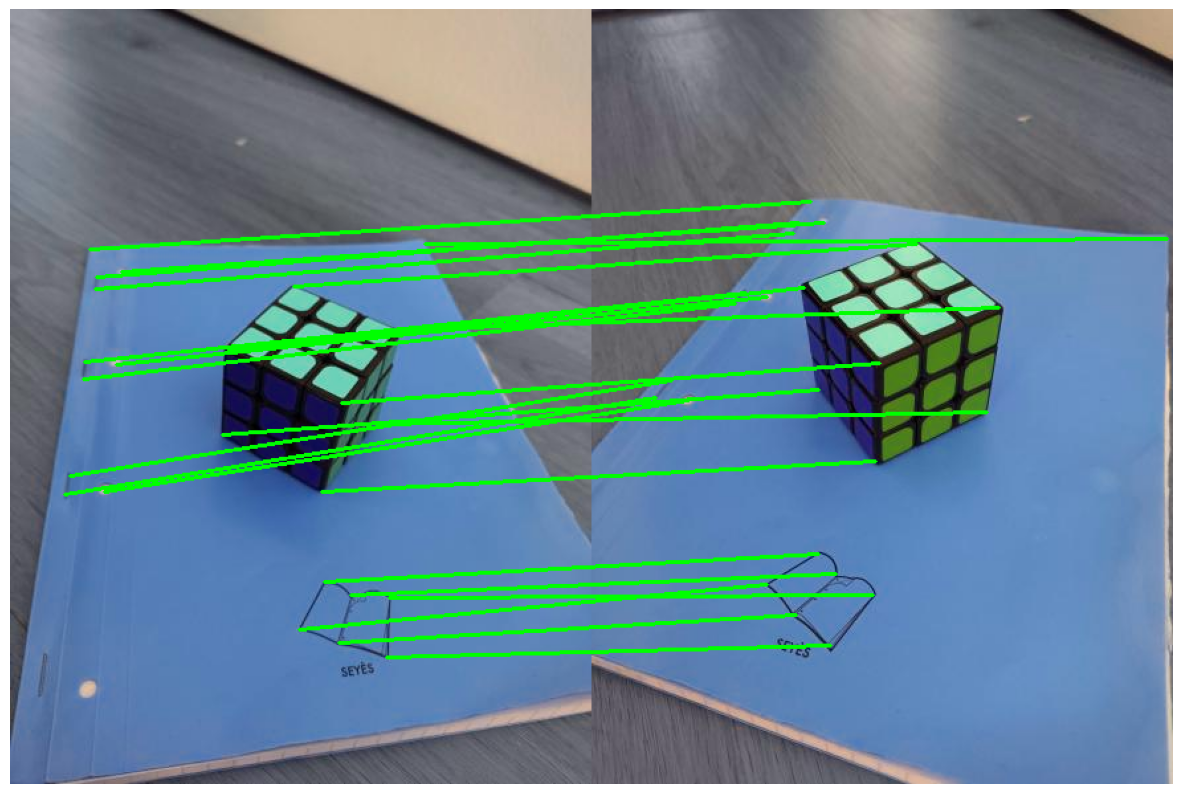

In [7]:
matching_points = create_matching_points(opl, opr)

display_matched_points(image_left, image_right, matching_points)

We compute the fundamental matrix with the 8-point algorithm, for 1000 iterations, and we keep the one with the most inliers. We then display the epipolar lines.

fundam quality:  0.002856599069785648  inliners 20
fundam norm quality:  0.0003617362777205764  inliners 16
opencv fundam quality: 6.778408034231215e-05 inliners 15


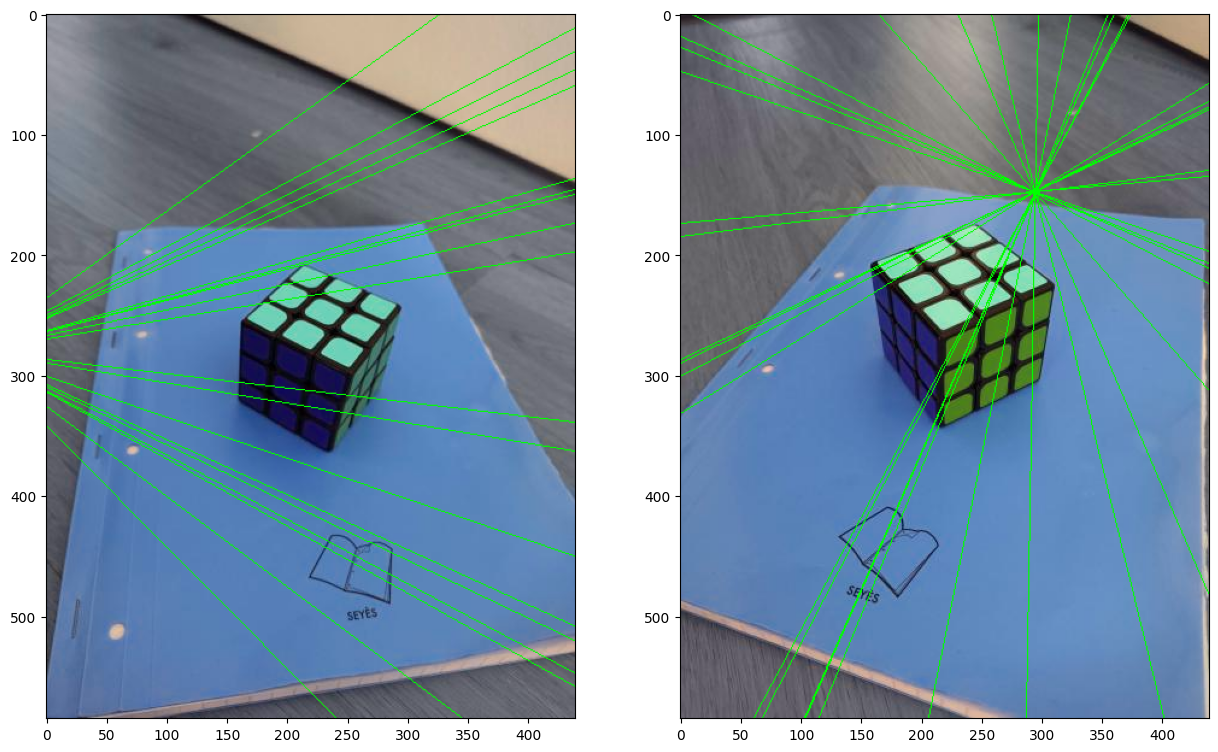

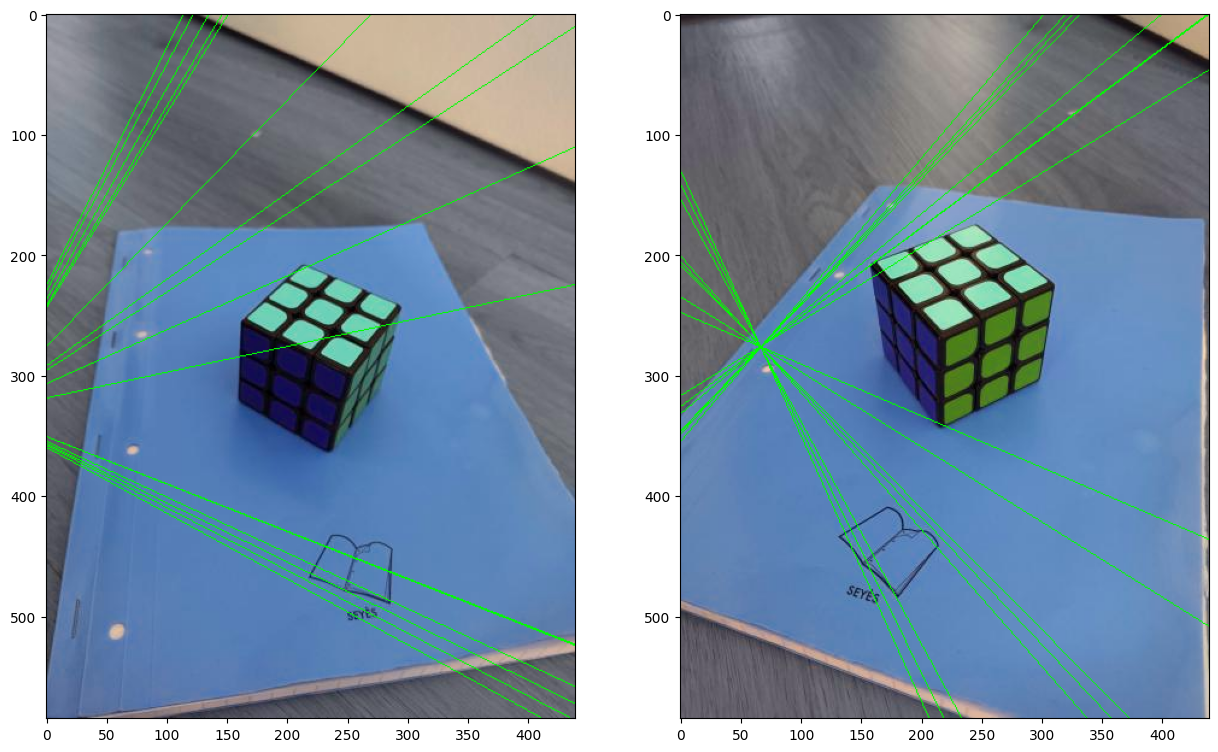

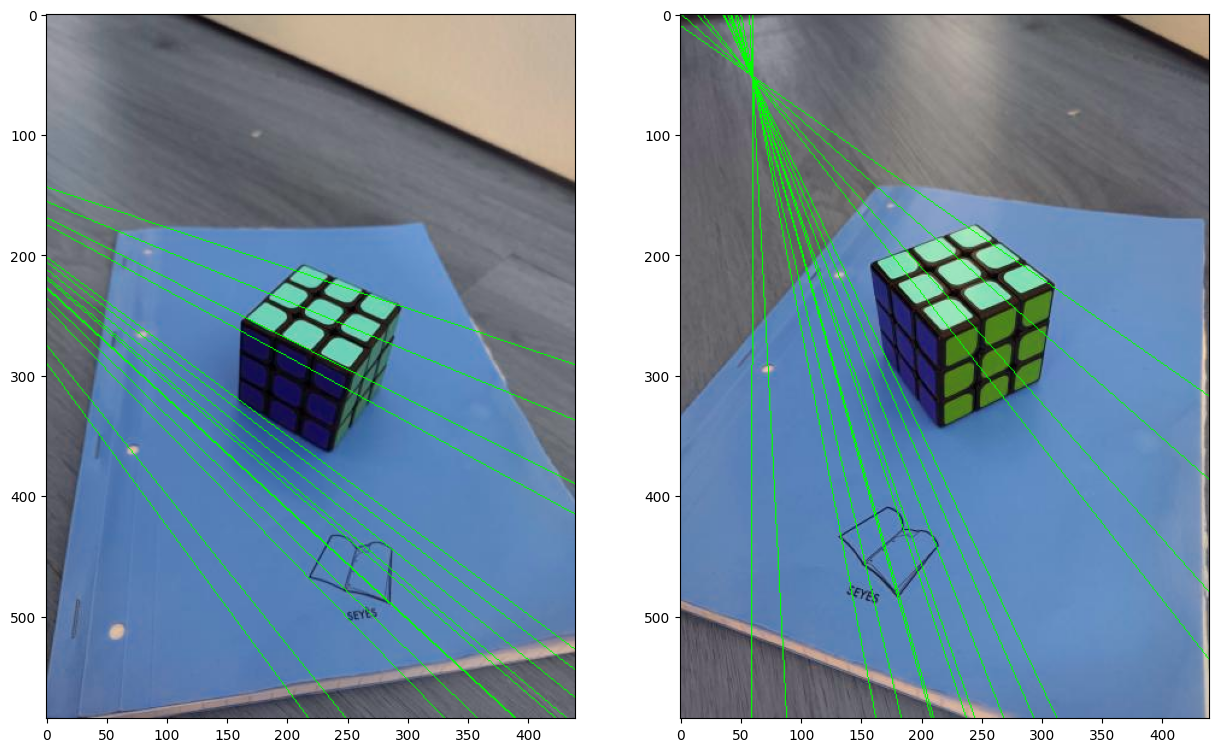

In [8]:
# CV implementation to compare

ptsleft = opl.copy()
ptsright = opr.copy()
p1s = []
p2s = []
for i in range(len(ptsleft)):
    p1s.append((ptsleft[i][0], ptsleft[i][1]))
    p2s.append((ptsright[i][0], ptsright[i][1]))

ptsleft = np.int32(p1s)
ptsright = np.int32(p2s)



tries = 100000

CVFundam, mask = cv.findFundamentalMat(ptsleft,ptsright,cv.FM_RANSAC, 1, 0.99, tries)

cvInlinerLeft = ptsleft[mask.ravel()==1]
cvInlinerRight = ptsright[mask.ravel()==1]


# use ransac to find the fundamental matrix

fundam, inliersLeft, inlinersRight = ransac_fundamental(opl, opr, normalized=False, k=tries, threshold=0.01)
fundam_norm, inliers_normLeft, inliers_normRight = ransac_fundamental(opl, opr, normalized=True, k=tries, threshold=0.001)

fundam_quality = fundamentalQualityArray(inliersLeft, inlinersRight, fundam)
fundam_norm_quality = fundamentalQualityArray(inliers_normLeft, inliers_normRight, fundam_norm)
opencv_fundam_quality = fundamentalQualityArray(cvInlinerLeft, cvInlinerRight, CVFundam)

print("fundam quality: ", fundam_quality , " inliners " + str(len(inliersLeft)))
print("fundam norm quality: ", fundam_norm_quality , " inliners " + str(len(inliers_normLeft)))
print("opencv fundam quality: " + str(opencv_fundam_quality) + " inliners " + str(len(cvInlinerLeft)))

display_epipolar_lines(image_left, image_right, inliersLeft, inlinersRight, fundam)
display_epipolar_lines(image_left, image_right, inliers_normLeft, inliers_normRight, fundam_norm)
display_epipolar_lines(image_left, image_right, cvInlinerLeft, cvInlinerRight, CVFundam)


As we can see, OpenCV outperforms us, which mean there is something wrong with our computations, they are also pretty consistent between the two images, which means that we may have a problem with the fundamental matrix computation, if so we couldn't find it, it may be a problem with the RANSAC or the 8-point algorithm.

## Normalizing

We tried to normalize the points and it gives us better results, still not as good as opencv but at least it is what we ecpected. It is due to the fact that the fundamental matrix is not scale invariant, so we need to normalize the points to have a better estimation, and it should also be more robust to eventual noise in the points.